## Dependencias

## Dependencias 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

## Cargar Datos

In [2]:
data = pd.read_sas('../data/churn.sas7bdat')
data.shape

(2801, 14)

In [3]:
data.head()

,V_ACCT_LGHT,C_IP,C_VMP,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS,TARGET,ID
0,128.0,b'No',b'Yes',25.0,45.07,99.0,16.78,91.0,11.01,3.0,2.70,1.0,0.0,1.0
1,107.0,b'No',b'Yes',26.0,27.47,103.0,16.62,103.0,11.45,3.0,3.70,1.0,0.0,2.0
2,137.0,b'No',b'No',0.0,41.38,110.0,10.30,104.0,7.32,5.0,3.29,0.0,0.0,3.0
3,65.0,b'No',b'No',0.0,21.95,83.0,19.42,111.0,9.40,6.0,3.43,4.0,1.0,11.0
4,168.0,b'No',b'No',0.0,21.90,71.0,8.92,128.0,6.35,2.0,3.02,1.0,0.0,13.0


## Partición

In [4]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
train.shape, valid.shape

((1960, 14), (841, 14))

## Naturaleza de variables 

In [9]:
um = ['ID']
varc = [v for v in data.columns if v[:2]=='V_']
vard = [v for v in data.columns if v[:2]=='C_']
vart = ['TARGET']
len(varc),len(vard)

(10, 2)

In [7]:
pd.crosstab(data['C_VMP'],data['TARGET']).to_clipboard()

In [11]:
pd.crosstab(pd.cut(data['V_ACCT_LGHT'],bins=4,include_lowest=True),data['TARGET']).to_clipboard()

In [12]:
pd.crosstab(pd.cut(data['V_CS_CALLS'],bins=4,include_lowest=True),data['TARGET']).to_clipboard()

## Scoring 

In [13]:
import pandas as pd 
from CreditScoringToolkit.frequency_table import frequency_table
from CreditScoringToolkit.DiscreteNormalizer import DiscreteNormalizer
from CreditScoringToolkit.WoeEncoder import WoeEncoder
from CreditScoringToolkit.WoeContinuousFeatureSelector import WoeContinuousFeatureSelector
from CreditScoringToolkit.WoeDiscreteFeatureSelector import WoeDiscreteFeatureSelector
from CreditScoringToolkit.CreditScoring import CreditScoring
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Normalize discrete variables

In [23]:
dn = DiscreteNormalizer(normalization_threshold=0.1,default_category='SMALL CATEGORIES')
dn.fit(train[vard])
Xt = dn.transform(train[vard])
frequency_table(Xt,vard)

****Frequency Table  C_VMP  ***


       Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
C_VMP                                                            
No           1423     0.72602              1423           0.72602
Yes           537     0.27398              1960           1.00000






In [24]:
unary = [v for v in vard if Xt[v].nunique()==1]
unary

[]

In [25]:
vard = [v for v in vard if v not in unary]

In [26]:
dn.fit(train[vard])
Xt = dn.transform(train[vard])
frequency_table(Xt,vard)

****Frequency Table  C_VMP  ***


       Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
C_VMP                                                            
No           1423     0.72602              1423           0.72602
Yes           537     0.27398              1960           1.00000






In [27]:
#Merge continuous features matrix with the normalized discrete predictors Matrix
Xt = pd.concat([Xt,train[varc]],axis=1) 

wcf = WoeContinuousFeatureSelector()
wdf = WoeDiscreteFeatureSelector()

#  Perform feature selection
wcf.fit(Xt[varc],train['TARGET'],
        max_bins=6,
        strictly_monotonic=True,
        iv_threshold=0.05,
        method='uniform',
        n_threads=20)

wdf.fit(Xt[vard],train['TARGET'],iv_threshold=0.05)


In [28]:

#  Create new matrix with discrete and discretized best features 
Xt = pd.concat([wdf.transform(Xt[vard]),wcf.transform(Xt[varc])],axis=1)

features = list(Xt.columns)

#  Print selection results
print("Best continuous features: ", wcf.selected_features)
print("Best discrete features: ",wdf.selected_features)
print("Best Features selected: ",features)

Best continuous features:  [{'feature': 'disc_V_CS_CALLS_2_uniform', 'iv': 0.5060375084782291, 'root_feature': 'V_CS_CALLS', 'nbins': '2', 'method': 'uniform'}, {'feature': 'disc_V_N_VM_MESS_2_uniform', 'iv': 0.05336257808038661, 'root_feature': 'V_N_VM_MESS', 'nbins': '2', 'method': 'uniform'}, {'feature': 'disc_V_T_EVE_CHG_3_uniform', 'iv': 0.10233919797031091, 'root_feature': 'V_T_EVE_CHG', 'nbins': '3', 'method': 'uniform'}, {'feature': 'disc_V_T_INT_CALLS_4_uniform', 'iv': 0.07813265893012503, 'root_feature': 'V_T_INT_CALLS', 'nbins': '4', 'method': 'uniform'}, {'feature': 'disc_V_T_INT_CHG_4_uniform', 'iv': 0.07795878362265034, 'root_feature': 'V_T_INT_CHG', 'nbins': '4', 'method': 'uniform'}]
Best discrete features:  {'C_VMP': 0.07341502817714282}
Best Features selected:  ['C_VMP', 'disc_V_CS_CALLS_2_uniform', 'disc_V_N_VM_MESS_2_uniform', 'disc_V_T_EVE_CHG_3_uniform', 'disc_V_T_INT_CALLS_4_uniform', 'disc_V_T_INT_CHG_4_uniform']


In [33]:
pd.DataFrame(wcf.selected_features)

,feature,iv,root_feature,nbins,method
0,disc_V_CS_CALLS_2_uniform,0.506038,V_CS_CALLS,2,uniform
1,disc_V_N_VM_MESS_2_uniform,0.053363,V_N_VM_MESS,2,uniform
2,disc_V_T_EVE_CHG_3_uniform,0.102339,V_T_EVE_CHG,3,uniform
3,disc_V_T_INT_CALLS_4_uniform,0.078133,V_T_INT_CALLS,4,uniform
4,disc_V_T_INT_CHG_4_uniform,0.077959,V_T_INT_CHG,4,uniform


## WoE Transformation

In [34]:
#  Weight of Evidence Transformation
we = WoeEncoder()
we.fit(Xt[features],train['TARGET'])
Xwt = we.transform(Xt[features])
Xwt.head()

,C_VMP,disc_V_CS_CALLS_2_uniform,disc_V_N_VM_MESS_2_uniform,disc_V_T_EVE_CHG_3_uniform,disc_V_T_INT_CALLS_4_uniform,disc_V_T_INT_CHG_4_uniform
0,-0.148645,-1.779315,-0.115325,-0.444314,0.076983,-0.650305
1,-0.148645,0.296370,-0.115325,-0.444314,0.223306,0.118373
2,-0.148645,0.296370,-0.115325,0.039501,0.223306,0.046794
3,-0.148645,0.296370,-0.115325,0.039501,-0.182197,0.046794
4,-0.148645,0.296370,-0.115325,0.039501,-0.182197,0.118373


## Aprendizaje con regresión logística

In [36]:
lr = LogisticRegression()
lr.fit(Xwt,train['TARGET'])
print("AUC for training: ",roc_auc_score(y_score=lr.predict_proba(Xwt)[:,1],y_true=train['TARGET']))

AUC for training:  0.7619371205943644


In [38]:
lr.coef_,lr.intercept_

(array([[-1.17669206, -1.02893254,  0.08498279, -1.08458691, -0.91998719,
         -1.02299533]]),
 array([-1.77684896]))

## Scoring 

In [39]:
cs = CreditScoring()
cs.fit(Xwt,we,lr)
cs.scorecard

points
feature                      attribute               
C_VMP                        No                    53
                             Yes                   74
disc_V_CS_CALLS_2_uniform    (-inf, 3.0]           66
                             (3.0, inf]             5
disc_V_N_VM_MESS_2_uniform   (-inf, 21.5]          58
                             (21.5, inf]           56
disc_V_T_EVE_CHG_3_uniform   (-inf, 13.573]        75
                             (13.573, 20.347]      59
                             (20.347, inf]         44
disc_V_T_INT_CALLS_4_uniform (-inf, 4.0]           53
                             (10.0, inf]           60
                             (4.0, 7.0]            64
                             (7.0, 10.0]           80
disc_V_T_INT_CHG_4_uniform   (-inf, 1.795]         70
                             (1.795, 2.7]          61
                             (2.7, 3.605]          59
                             (3.605, inf]          38

In [40]:
#  Applying all transformations to the validation data is now easy and straightforward
#  we can compute AUC to check model overfitting
Xv = pd.concat([wdf.transform(dn.transform(valid[vard])),wcf.transform(valid[varc])],axis=1)
Xwv = we.transform(Xv)
print("AUC for validation: ",roc_auc_score(y_score=lr.predict_proba(Xwv)[:,1],y_true=valid['TARGET']))

AUC for validation:  0.7192253914988814


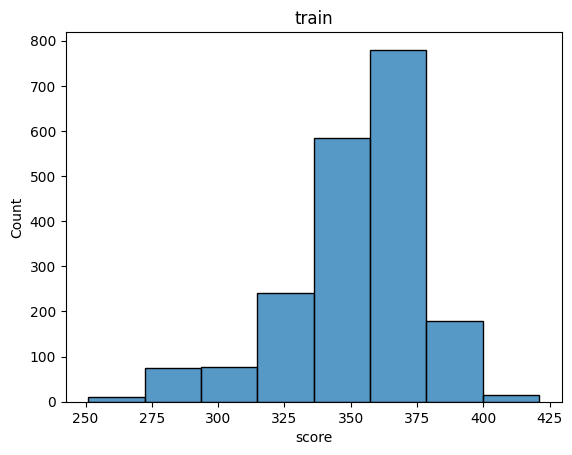

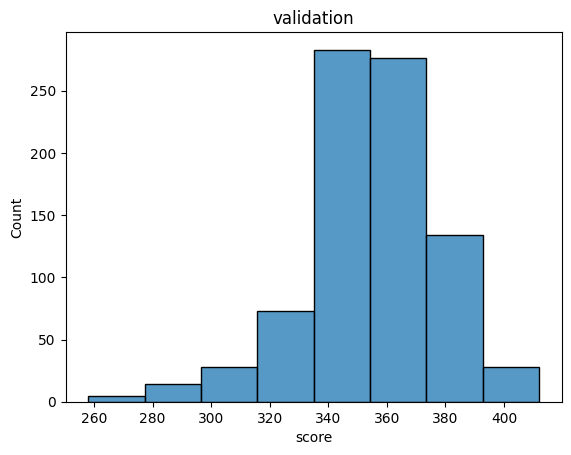

In [41]:
#  We can check the score transformation distributions for training and validation
score = pd.concat([pd.concat([cs.transform(we.inverse_transform(Xwv))[['score']].assign(sample='validation'),valid['TARGET']],axis=1),
pd.concat([cs.transform(we.inverse_transform(Xwt))[['score']].assign(sample='train'),train['TARGET']],axis=1)
                  ],ignore_index=True)

for s,d in score.groupby('sample'):
    plt.figure()
    plt.title(s)
    sns.histplot(d['score'],legend=True,fill=True,bins=8)

<Figure size 640x480 with 0 Axes>

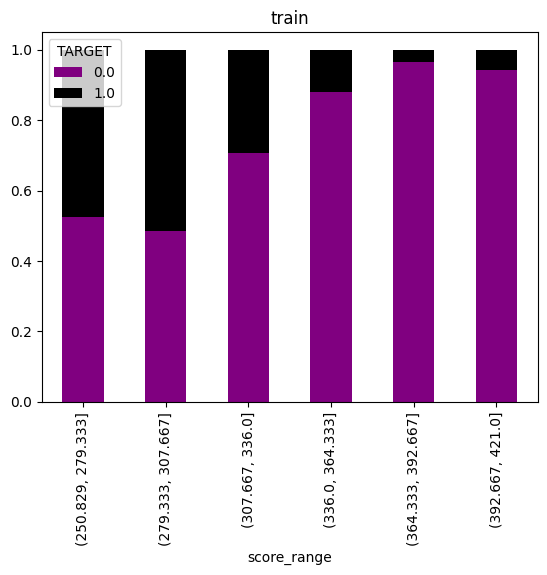

<Figure size 640x480 with 0 Axes>

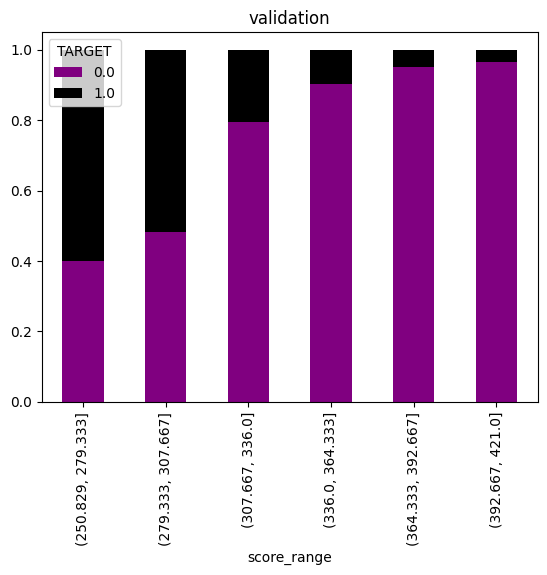

In [42]:
#   Finally, we can observe that, the greater the score, the lower the probability of being a 
#   bad customer (label=1) for both samples. Now all complexity is absorbed   
score['score_range'] = pd.cut(score['score'],bins=6,include_lowest=True).astype(str)
for s,d in score.groupby('sample'):
    aux = d.pivot_table(index='TARGET',
                        columns='score_range',
                        values='score',
                        aggfunc='count',
                        fill_value=0)
    aux/=aux.sum()
    aux = aux.T
    plt.figure()
    ax = aux.plot(kind='bar',stacked=True,color=['purple','black'])
    plt.title(s)

In [47]:
score['score_range'] = pd.cut(score['score'],bins=6,include_lowest=True).astype(str)

In [49]:
score.groupby(['score_range','TARGET','sample']).count().to_clipboard()

In [52]:
cs.pdo,cs.offset,cs.base_score

(20, np.float64(400.0), 400)